#Fence Detection
In this notebook we show all 6 methods of fence detection:
* Morphological Gradients
* Sobel edge detection
* Probabilistic Hough line transform
* Standard Hough line transform
* Temperature Thresholding
* Hybrid approach: Temperature thresholding and standard Hough line transform.

We also tested out Telea and Navier-stokes inpainting on the first few mask detection algorithms.
This notebook provides a qualitative evaluation; Notebook 2 contains the quantitative analysis based on the best-performing methods identified qualitatively.

## Morphological Gradients

In [1]:
#Mounting the google drive to access the images
#This can be replace with path where the images are currently stored if not using google colab (local computer)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#Importing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

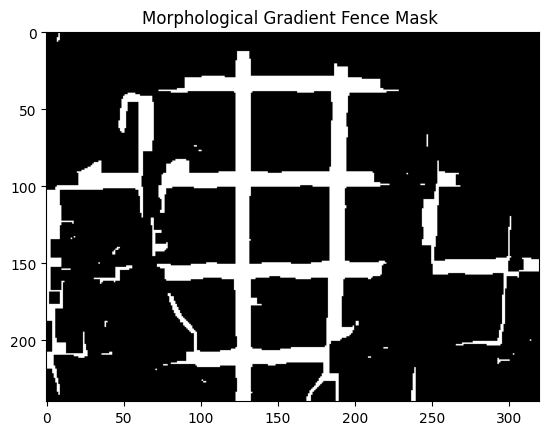

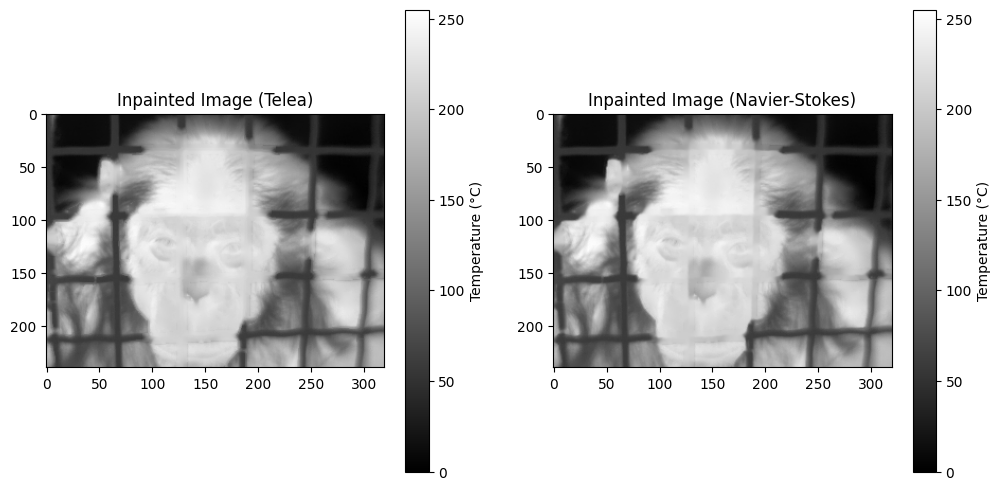

In [7]:
csv_file = '/content/drive/MyDrive/Final Code/Simple Image to test.csv'
#Another image to test: csv_file = '/content/drive/MyDrive/Final Code/Second simple image.csv'

#Read csv file using Pandas dataframe
#Then transform it into a numpy array of orignal shape: 240 x 320
thermal_image = pd.read_csv(csv_file, header=None).values.astype(np.float32)

#Convert raw temp. values -> 0-255 image range (using 8-bit integers)
norm_thermal_img = cv2.normalize(thermal_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

#Kernel size = 3
kernel = np.ones((3, 3), np.uint8)

# Step 1: Calculate the morphological gradient for the thermal image
#Morphological gradient = Dilation − Erosion
Morphological_gradient = cv2.morphologyEx(norm_thermal_img, cv2.MORPH_GRADIENT, kernel)

# Step 2: Creating binary mask
#cv2.threshold() ->Thresholds an image and makes it into a binary mask
#->cv2.THRESH_OTSU ->Automatically finds the best threshold by analyzing the histogram of pixel intensities
threshold_num, mask_fence = cv2.threshold(Morphological_gradient, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 3: Applying cv2.MORPH_CLOSE to refine mask
kernel = np.ones((7, 7), np.uint8)
#7 x 7 is optimal
#8 x 8 mask is too dialted and inpainting uses fence to fill in
#5 x 5 is too low and not enough fo the fence is inpainted

mask_fence = cv2.morphologyEx(mask_fence.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

# Step 4: Visualising:
#Fence mask output
plt.imshow(mask_fence, cmap='gray')
plt.title('Morphological Gradient Fence Mask ')
plt.show()

#Try both inpainting methods: TELEA and NAVIER-STOKES
inpainted_image_telea = cv2.inpaint(norm_thermal_img, mask_fence.astype(np.uint8), 5, cv2.INPAINT_TELEA)
inpainted_image_ns = cv2.inpaint(norm_thermal_img, mask_fence.astype(np.uint8), 5, cv2.INPAINT_NS)

#Showing inpainted images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(inpainted_image_telea, cmap='gray')
plt.colorbar(label='Temperature (°C)')
plt.title('Inpainted Image (Telea)')

plt.subplot(1, 2, 2)
plt.imshow(inpainted_image_ns, cmap='gray')
plt.colorbar(label='Temperature (°C)')
plt.title('Inpainted Image (Navier-Stokes)')

plt.show()


## Edge Detection

78.0


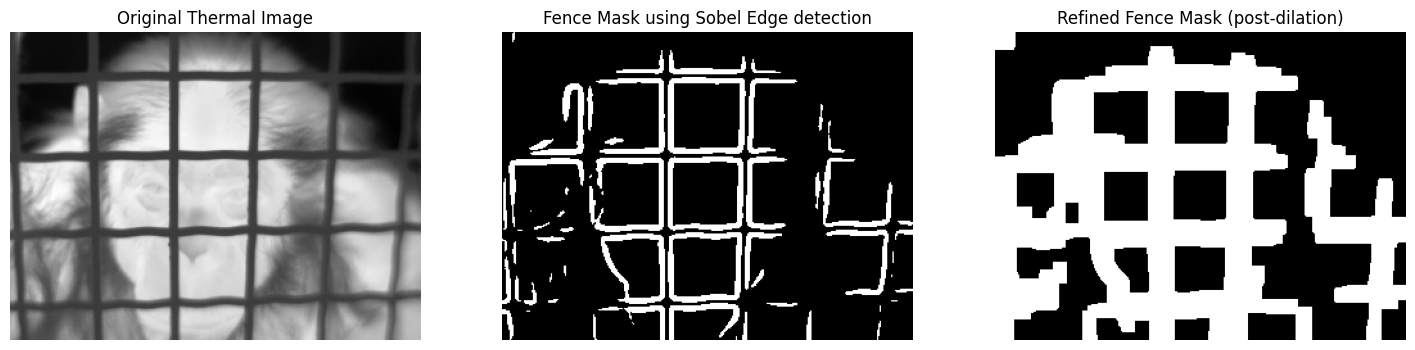

In [13]:
#Using the normalised thermal image like before:
#Re-doing it avoid an confounds from other cells
thermal_image = pd.read_csv(csv_file, header=None).values.astype(np.float32)
norm_thermal_img = cv2.normalize(thermal_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


#Kernel size of 9
#Sobel edge detection in x axis ->(1,0) Finds horizontal edges (changes along X-axis)
sobel_x = cv2.Sobel(norm_thermal_img, cv2.CV_64F, 1, 0, ksize=9)

#Sobel edge detection in y axis ->(0,1) Finds vertical edges (changes along Y-axis)
sobel_y = cv2.Sobel(norm_thermal_img, cv2.CV_64F, 0, 1, ksize=9)

#Computes the gradient magnitude by combining both horizontal and vertical edges
edges = cv2.magnitude(sobel_x, sobel_y)

#When computing sobel filter, using 64-bit floating point format (CV_64F) to capture full edge information (more accurate).
#But Otsu thresholding, requires 8-bit or 16-bit single channel images; so we re-convert:
edges_norm = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

#Applying THRESH_OTSU thresholding
threshold_num, mask_fence = cv2.threshold(edges_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(threshold_num)

#Alternative way would be manual threshold:
#edges_normalized = cv2.normalize(edges, None, 0, 1, cv2.NORM_MINMAX)
#Apply manual threshold for mask e.g.
#fence_mask = (edges_norm > 0.3).astype(np.uint8)

#Refine mask through morphological operations (dilation + closing)
kernel = np.ones((10, 10), np.uint8)
dilated_mask = cv2.dilate(mask_fence, kernel, iterations=1)
Sobel_mask = cv2.morphologyEx(dilated_mask, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(norm_thermal_img, cmap='gray')
plt.title("Original Thermal Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_fence, cmap='gray')
plt.title("Fence Mask using Sobel Edge detection")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(Sobel_mask, cmap='gray')
plt.title("Refined Fence Mask (post-dilation)")
plt.axis("off")

plt.show()

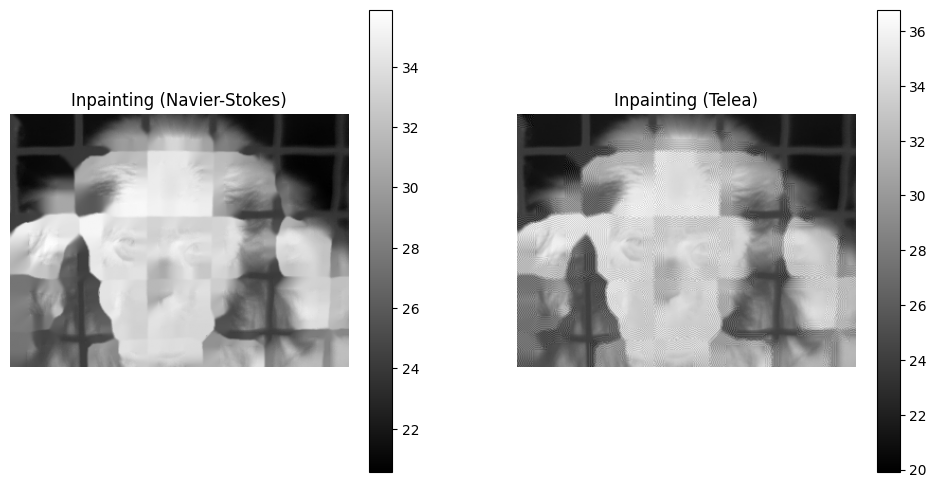

In [15]:
#Inpainting:
inpainted_ns = cv2.inpaint(thermal_image, Sobel_mask, 3, cv2.INPAINT_NS)
inpainted_telea = cv2.inpaint(thermal_image, Sobel_mask, 3, cv2.INPAINT_TELEA)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(inpainted_ns, cmap='gray')
plt.title("Inpainting (Navier-Stokes)")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(inpainted_telea, cmap='gray')
plt.title("Inpainting (Telea)")
plt.colorbar()
plt.axis("off")
plt.show()

## Temperature Threshold

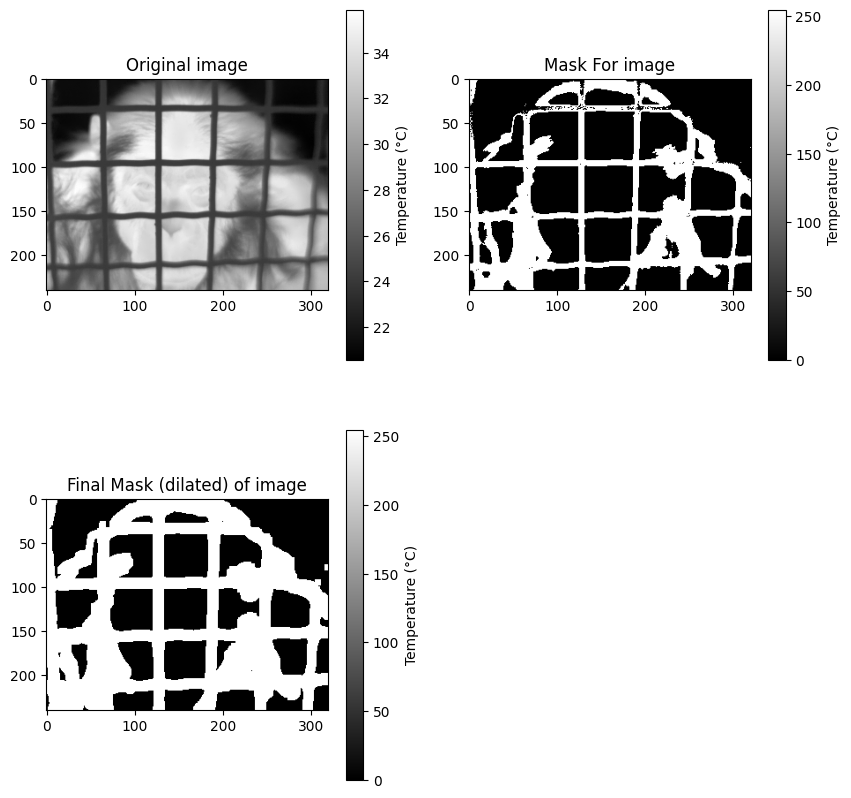

In [16]:
#Re-writing this to avoid other cell running confounds:
#Also we need to raw temp. values
data = pd.read_csv(csv_file, header=None)
thermal_image = data.to_numpy()
lower_threshold = 24
upper_threshold = 28

#Creating mask of fence: where the temperature is within the threshold will be white
temp_fence_mask = (thermal_image >= lower_threshold) & (thermal_image <= upper_threshold)

#Dilating that fence-mask + Normalise:
temp_fence_mask = temp_fence_mask.astype(np.uint8) * 255
kernel = np.ones((3, 3))
dilated_mask_temp = cv2.dilate(temp_fence_mask, kernel, iterations=3)

#Show
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('Original image')
plt.imshow(thermal_image, cmap='gray')
plt.colorbar(label='Temperature (°C)')

plt.subplot(2, 2, 2)
plt.title('Mask For image')
plt.imshow(temp_fence_mask, cmap='gray')
plt.colorbar(label='Temperature (°C)')

plt.subplot(2, 2, 3)
plt.title('Final Mask (dilated) of image')
plt.imshow(dilated_mask_temp, cmap='gray')
plt.colorbar(label='Temperature (°C)')
plt.show()


#Hough Transform
Two methods of hough Transform:
* A) Standard Hough Line Transform: detects straight full lines (infinite). Higher computational cost. Best for Long, continuous structures e.g. roads.

* B) Probabilistic Hough Line Transform: detects finite line segments. Lower computational cost as it randomly samples edge points. Best for Broken, dashed, or short lines (broken fences, cracks). Connects gaps.

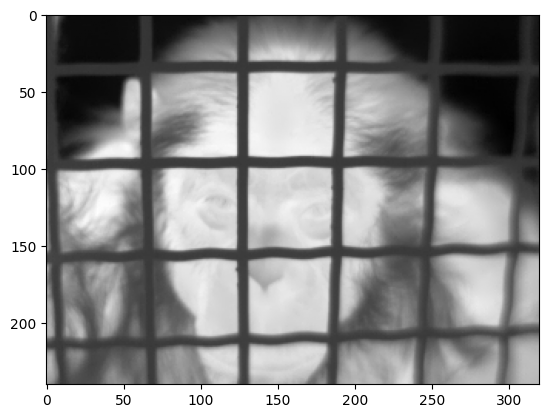

In [17]:
#Re-doing to avoid confounds
raw_thermal_img = pd.read_csv(csv_file, header=None).to_numpy()
temp_norm_img = cv2.normalize(raw_thermal_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.imshow(temp_norm_img, cmap='gray')
plt.show()

##Standard Hough Line Transform

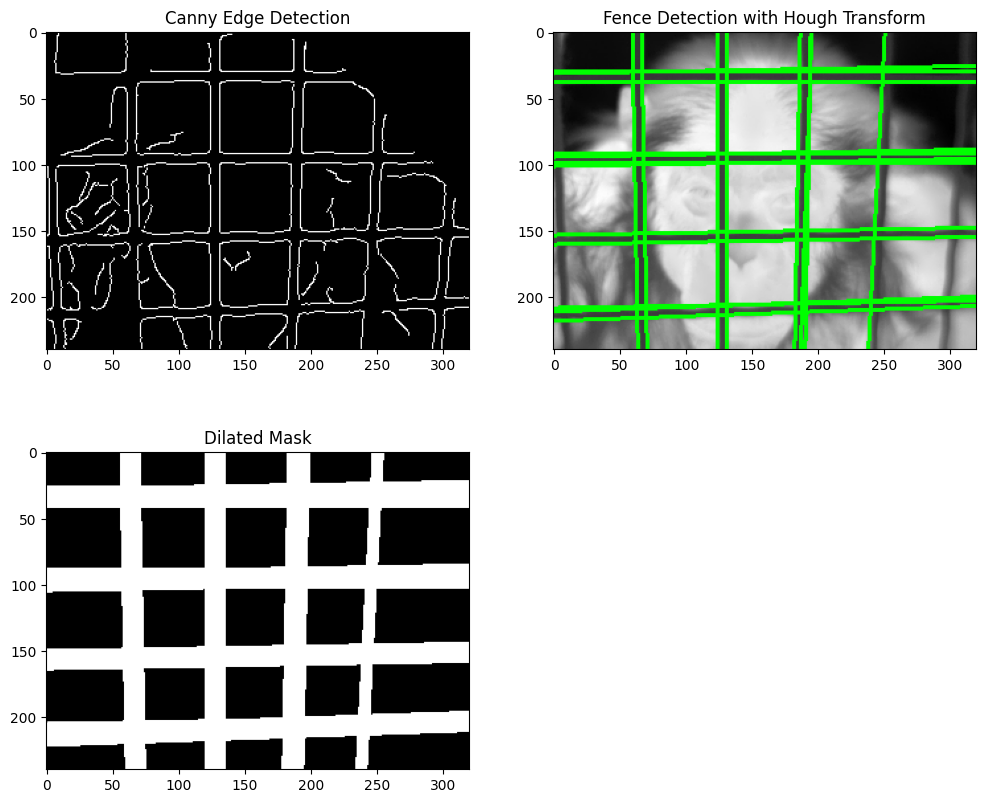

In [18]:
##################### Adapted from OpenCV   ###########
##USING Standard Hough Line Transform

#1) Gaussian Filter/ blur to smooth out image, help edge detection (smooth out noise)
gauss_blur = cv2.GaussianBlur(temp_norm_img, (7, 7), 0) #7 kernel used

#Canny Edge Detection to get a binary image of edges (then will detect straight lines from edges)
#Chosing the threshold of what is considered a strong edge
#Lower_thres: 20
#upper_thres: 120
#Only includes strong edges

canny_edges = cv2.Canny(gauss_blur, 20, 120)

#Hough lines threshold paramters represents the minium number of votes required for a line to be valid
#Only lines that received at least 75 votes will be returned by cv2.HoughLines (80 also worked)
#votes = how many times the curves in the hough space intersect

hough_lines_std = cv2.HoughLines(canny_edges, rho=1, theta=np.pi / 180, threshold=75)

#To display all lines detect need to convert into BGR image (lines are coloured)
temp_color = cv2.cvtColor(temp_norm_img, cv2.COLOR_GRAY2BGR)

#To create mask of lines detected
mask_standard = np.zeros_like(temp_norm_img)

#Drawing the straight lines detected
if hough_lines_std is not None:
    for line in hough_lines_std:
        rho, theta = line[0]
        #Convert from polar form to cartesian form (ρ, θ) to (x1, y1)
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))

        #Draw green lines onto the image
        cv2.line(temp_color, (x1, y1), (x2, y2), (0, 255, 0), 2)
        #drawing these lines also on the mask
        cv2.line(mask_standard, (x1, y1), (x2, y2), 255, 2)


plt.figure(figsize=(12, 10))

#Dilating lines on mask
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
mask_HOUGH_standard = cv2.dilate(mask_standard, kernel, iterations=1)

plt.subplot(2, 2, 1)
plt.imshow(canny_edges, cmap="gray")
plt.title("Canny Edge Detection")

plt.subplot(2, 2, 2)
plt.imshow(temp_color)
plt.title("Fence Detection with Hough Transform")

plt.subplot(2, 2, 3)
plt.imshow(mask_HOUGH_standard, cmap="gray")
plt.title("Dilated Mask")
plt.show()

##Probabilistic Hough Line Transform

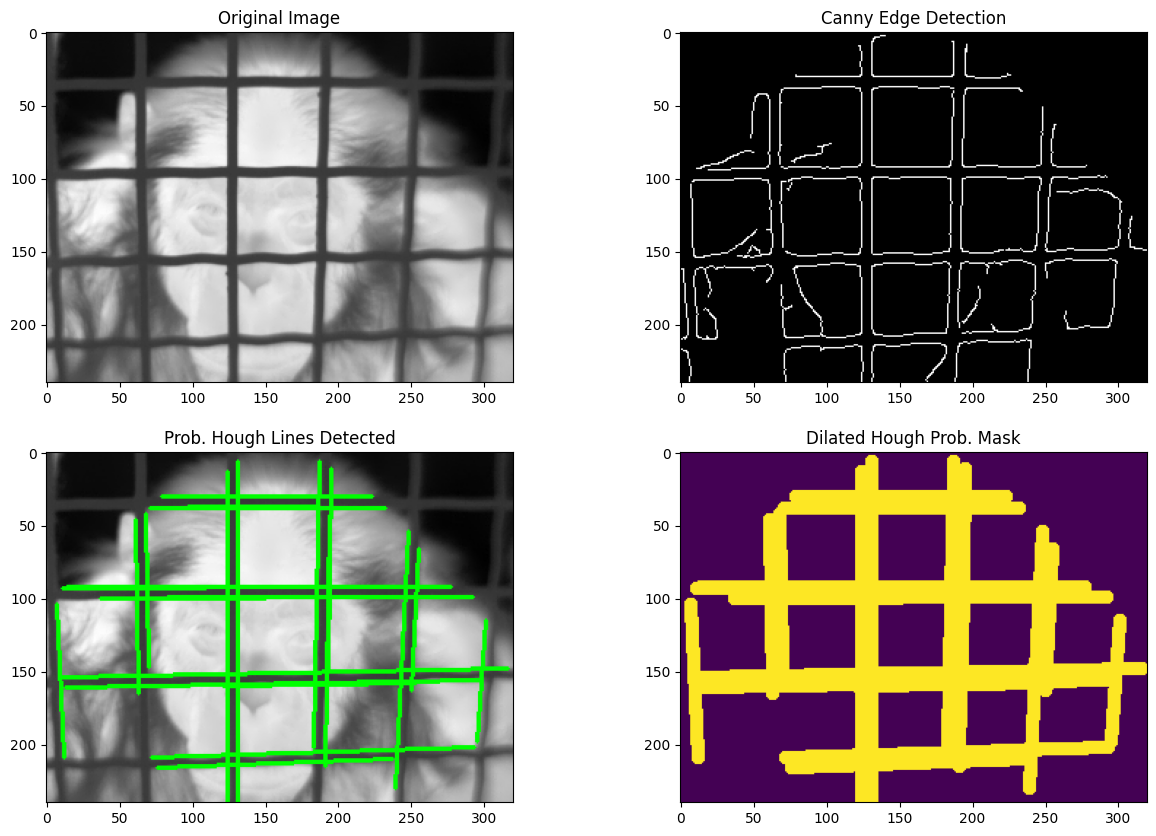

In [22]:
##USING Probabilistic Hough Line Transform

#1) Apply Gaussian Blur to help reduce noise: gauss_blur (from before!)

#2) Canny Edge detection
canny_edge = cv2.Canny(gauss_blur, threshold1=30, threshold2=180)
#Morphological transformations to help fill in gaps
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
closed_edges = cv2.morphologyEx(canny_edge, cv2.MORPH_CLOSE, kernel)

#3) Hough transform to get lines
#Other option tested
#lines = cv2.HoughLinesP(closed_edges, rho=1, theta=np.pi / 180, threshold=10, minLineLength=5, maxLineGap=30)
#lines = cv2.HoughLinesP(closed_edges, rho=1, theta=np.pi / 180, threshold=20, minLineLength=20, maxLineGap=25)
hough_prob_lines = cv2.HoughLinesP(closed_edges, rho=1, theta=np.pi / 180, threshold=50, minLineLength=5, maxLineGap=30)
#Image made grayscale into colour to put coloured lines
temp_color = cv2.cvtColor(temp_norm_img, cv2.COLOR_GRAY2BGR)

#to create mask
prob_fence_mask = np.zeros_like(temp_norm_img)

for line in hough_prob_lines:
    x1, y1, x2, y2 = line[0]
    #Drawing lines but making them 3 pixels thick
    cv2.line(prob_fence_mask, (x1, y1), (x2, y2), 255, 3)
    #drawiing hough transform lines ontop of image to show
    cv2.line(temp_color, (x1, y1), (x2, y2), (0, 255, 0), 2)

#Dilating
dilated_mask_hough_prob = cv2.dilate(prob_fence_mask, kernel, iterations=1)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(temp_norm_img, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Canny Edge Detection')
plt.imshow(canny_edge, cmap='gray')

plt.subplot(2, 2, 3)
plt.title('Prob. Hough Lines Detected')
plt.imshow(temp_color)

plt.subplot(2, 2, 4)
plt.title('Dilated Hough Prob. Mask')
plt.imshow(dilated_mask_hough_prob)
plt.show()




#Hybrid approach: Temperature thresholding and hough line transform


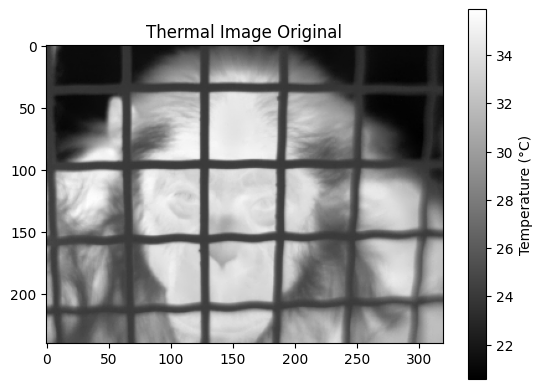

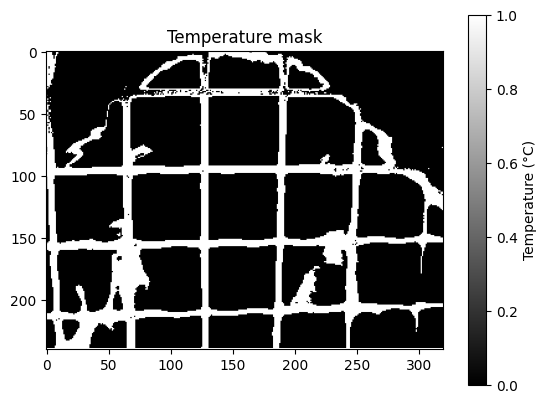

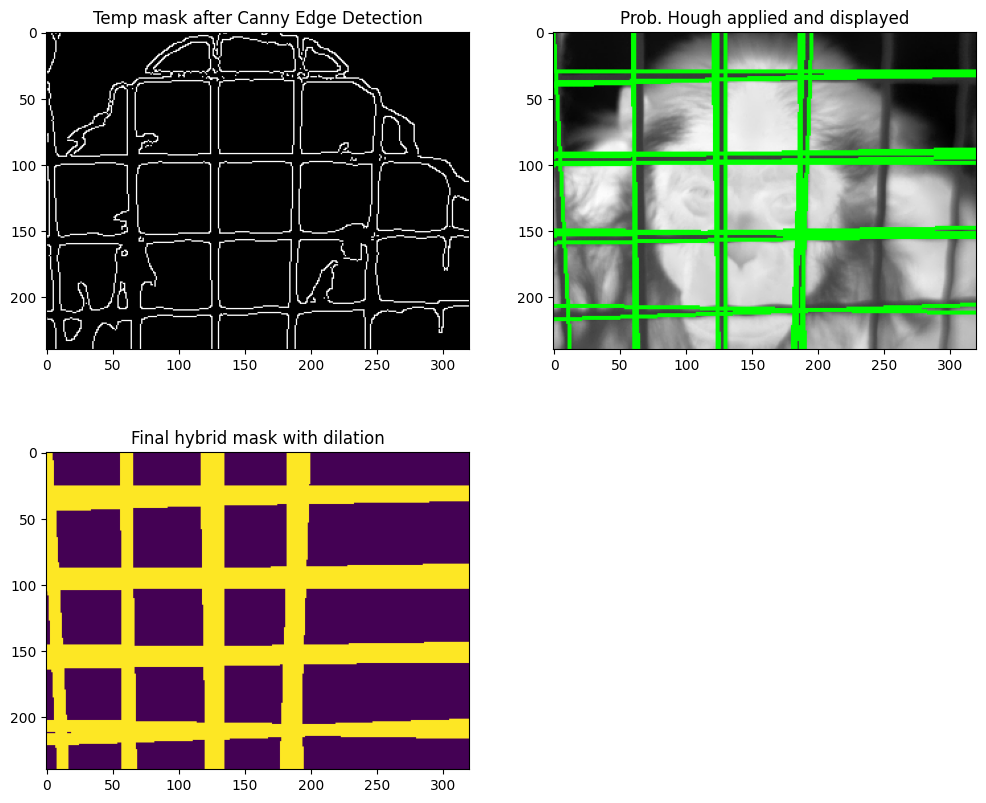

In [31]:
#COMBINING temp + Hough
#Setting Temperature Thresholds
lower_threshold = 24
upper_threshold = 26

#Creating mask of fence: where the temperature is within the threshold will be white
fence_mask = (raw_thermal_img >= lower_threshold) & (raw_thermal_img <= upper_threshold)
fence_mask_norm = (fence_mask * 255).astype(np.uint8)
guass_blur = cv2.GaussianBlur(fence_mask_norm, (7, 7), 0)
canny_edge_combined = cv2.Canny(guass_blur, 20, 120)

combined_lines = cv2.HoughLines(canny_edge_combined, rho=1, theta=np.pi / 180, threshold=75)
temp_colour = cv2.cvtColor(temp_norm_img, cv2.COLOR_GRAY2BGR)
hough_mask = np.zeros_like(temp_norm_img)

#Drawing the straight lines detected
if combined_lines is not None:
    for line in combined_lines:
        rho, theta = line[0]
        #Convert from polar form to cartesian form (ρ, θ) to (x1, y1)
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))

        #Draw green lines onto the image
        cv2.line(temp_colour, (x1, y1), (x2, y2), (0, 255, 0), 2)
        #drawing these lines also on the mask
        cv2.line(hough_mask, (x1, y1), (x2, y2), 255, 2)


plt.title('Thermal Image Original')
plt.imshow(raw_thermal_img, cmap='gray')
plt.colorbar(label='Temperature (°C)')
plt.show()

plt.title('Temperature mask')
plt.imshow(fence_mask, cmap='gray')
plt.colorbar(label='Temperature (°C)')
plt.show()

plt.figure(figsize=(12, 10))

#Dilating lines on mask
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))# kernal size for dilation
dilated_mask_combined = cv2.dilate(hough_mask, kernel, iterations=1)

plt.subplot(2, 2, 1)
plt.imshow(canny_edge_combined, cmap="gray")
plt.title("Temp mask after Canny Edge Detection")

plt.subplot(2, 2, 2)
plt.imshow(temp_colour)
plt.title("Prob. Hough applied and displayed")

plt.subplot(2, 2, 3)
plt.imshow(dilated_mask_combined)
plt.title("Final hybrid mask with dilation")

plt.show()

#Saving Masks
Below is the code used to save the masks to then create results figures.

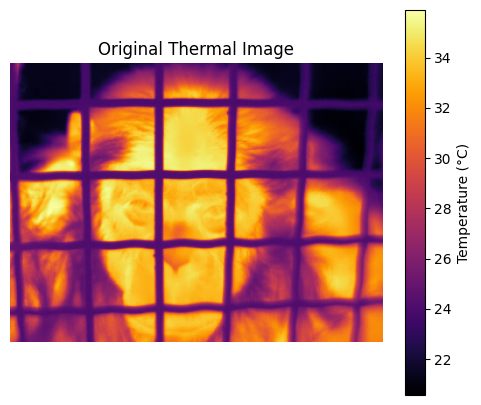

In [32]:
#plotting our original image:
raw_Thermal_img = pd.read_csv(csv_file, header=None).values.astype(np.float32)

plt.figure(figsize=(6, 5))
thermal_img = plt.imshow(raw_Thermal_img, cmap='inferno')
plt.title('Original Thermal Image')
plt.axis('off')

cbar = plt.colorbar(thermal_img)
cbar.set_label("Temperature (°C)")
plt.savefig("thermal_fence.pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

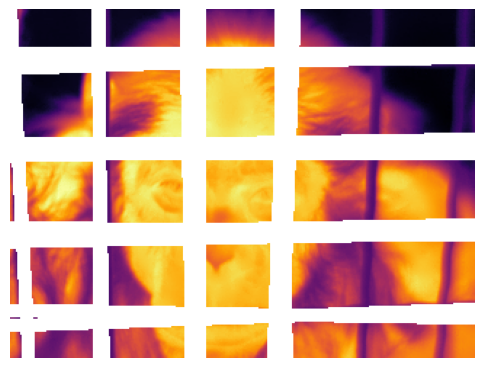

In [34]:
#Plotting the mask detected:
thermal_image_original = thermal_image.copy()
thermal_norm = cv2.normalize(thermal_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

thermal_colored = cv2.applyColorMap(thermal_norm, cv2.COLORMAP_INFERNO)

mask = (dilated_mask_combined > 0).astype(np.uint8)

overlayed = thermal_colored.copy()
overlayed[mask == 1] = 255 # white

overlayed_rgb = cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 5))
plt.imshow(overlayed_rgb)
plt.axis('off')
plt.imshow(thermal_image_original, cmap='inferno', alpha=0)

#saving figure
plt.savefig("MASK_1.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()


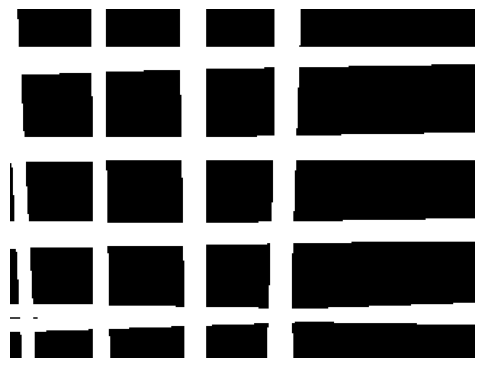

In [35]:
#Saving our mask
plt.figure(figsize=(6, 5))
plt.imshow(dilated_mask_combined, cmap = "gray")
plt.axis('off')
plt.savefig("MASK_2.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)
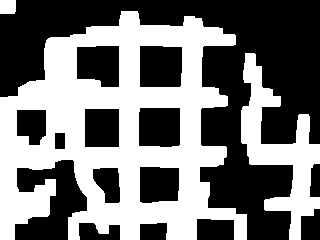

In [36]:
#All masks tested: Sobel_mask, morphology_mask, dilated_mask_temp, mask_HOUGH_standard, dilated_mask_hough_prob, dilated_mask_combined
#e.g.
Sobel_mask